# Bangalore 

In [1]:
# importing required library 

import pandas as pd
import numpy as np
import ast
import re

# Convert "₹ 4 Lakh" → 400000
def clean_number(val):
    if not isinstance(val, str):
        return np.nan
    val = val.replace('₹', '').replace(',', '').strip()
    if 'Lakh' in val:
        try:
            return float(val.replace('Lakh', '').strip()) * 1e5
        except:
            return np.nan
    elif val:
        try:
            return float(val)
        except:
            return np.nan
    return np.nan

# Extract numeric year from strings like "Feb 2018"
def extract_year(val):
    if isinstance(val, int):
        return val
    if isinstance(val, str):
        match = re.search(r'\d{4}', val)
        if match:
            return int(match.group(0))
    return np.nan

# Convert object strings to dict if necessary
def safe_parse(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except:
            return {}
    elif isinstance(val, dict):
        return val
    return {}

# Extract key-value dicts from lists
def extract_kv_dict(lst):
    if isinstance(lst, list):
        return {item.get('key', ''): item.get('value', '') for item in lst if isinstance(item, dict)}
    return {}

# Extract features from a row
def extract_features_from_row(row):
    car = safe_parse(row.get('new_car_detail', {}))
    overview = safe_parse(row.get('new_car_overview', {}))
    specs = safe_parse(row.get('new_car_specs', {}))

    overview_top = overview.get('top', [])
    specs_top = specs.get('top', [])
    specs_data = specs.get('data', [])

    overview_dict = extract_kv_dict(overview_top)
    specs_dict = extract_kv_dict(specs_top)

    engine_specs = {}
    dimensions_specs = {}
    misc_specs = {}

    for section in specs_data:
        heading = section.get('heading', '')
        spec_list = section.get('list', [])
        parsed = extract_kv_dict(spec_list)

        if 'Engine' in heading:
            engine_specs = parsed
        elif 'Dimension' in heading:
            dimensions_specs = parsed
        elif 'Misc' in heading:
            misc_specs = parsed

    return {
        'brand': car.get('oem'),
        'model': car.get('model'),
        'variant': car.get('variantName'),
        'fuel_type': car.get('ft'),
        'body_type': car.get('bt'),
        'transmission': car.get('transmission'),
        'owner_type': car.get('owner'),
        'owner_number': car.get('ownerNo'),
        'kms_driven': int(car.get('km', '0').replace(',', '')) if 'km' in car else np.nan,
        'model_year': car.get('modelYear'),
        'registration_year': extract_year(overview_dict.get('Registration Year', car.get('modelYear'))),
        'engine_displacement': int(overview_dict.get('Engine Displacement', '0').replace('cc', '').replace('CC', '').strip()) if 'Engine Displacement' in overview_dict else np.nan,
            'mileage': (
        float(re.search(r'\d+\.?\d*', specs_dict.get('Mileage', '')).group())
        if 'Mileage' in specs_dict and re.search(r'\d+\.?\d*', specs_dict['Mileage']) else np.nan
    ),
    'max_power': (
        float(re.search(r'\d+\.?\d*', specs_dict.get('Max Power', '')).group())
        if 'Max Power' in specs_dict and re.search(r'\d+\.?\d*', specs_dict['Max Power']) else np.nan
    ),
    'torque': (
        float(re.search(r'\d+\.?\d*', specs_dict.get('Torque', '')).group())
        if 'Torque' in specs_dict and re.search(r'\d+\.?\d*', specs_dict['Torque']) else np.nan
    ),
    'color': engine_specs.get('Color', ''),
    'engine_type': engine_specs.get('Engine Type', ''),
    'gear_box': misc_specs.get('Gear Box', ''),
    'drive_type': misc_specs.get('Drive Type', ''),
    'steering_type': misc_specs.get('Steering Type', ''),
    'top_speed': (
        int(re.search(r'\d+', misc_specs.get('Top Speed', '')).group())
        if 'Top Speed' in misc_specs and re.search(r'\d+', misc_specs['Top Speed']) else np.nan
    ),
    'acceleration': (
        float(re.search(r'\d+\.?\d*', misc_specs.get('Acceleration', '')).group())
        if 'Acceleration' in misc_specs and re.search(r'\d+\.?\d*', misc_specs['Acceleration']) else np.nan
    ),


        'price': clean_number(car.get('price'))
    }

# Master preprocessing function
def preprocess_used_car_dataset(df):
    df = df.copy()

    # Parse relevant columns
    for col in ['new_car_detail', 'new_car_overview', 'new_car_specs']:
        df[col] = df[col].apply(safe_parse)

    # Extract features row-wise
    feature_rows = df.apply(extract_features_from_row, axis=1)
    final_df = pd.DataFrame(feature_rows.tolist())
    return final_df


In [2]:
# Load data
df_raw = pd.read_excel("bangalore_cars.xlsx")

# Preprocess and extract features
df_bangalore = preprocess_used_car_dataset(df_raw)


In [3]:
#add city column to dataframe
df_bangalore['City'] = 'Bangalore'
#final dataframe
df_bangalore

,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,torque,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City
0,Maruti,Maruti Celerio,VXI,Petrol,Hatchback,Manual,3rd Owner,3,120000,2015,...,90.00,White,K10B Engine,5 Speed,FWD,Power,150.0,15.05,400000.0,Bangalore
1,Ford,Ford Ecosport,1.5 Petrol Titanium BSIV,Petrol,SUV,Manual,2nd Owner,2,32706,2018,...,150.00,White,Ti-VCT Petrol Engine,5 Speed,FWD,Power,NaN,NaN,811000.0,Bangalore
2,Tata,Tata Tiago,1.2 Revotron XZ,Petrol,Hatchback,Manual,1st Owner,1,11949,2018,...,114.00,Red,Revotron Engine,5 Speed,FWD,Power,150.0,14.30,585000.0,Bangalore
3,Hyundai,Hyundai Xcent,1.2 Kappa S Option,Petrol,Sedan,Manual,1st Owner,1,17794,2014,...,113.75,Others,Kappa VTVT Petrol Engine,5 Speed,FWD,Power,172.0,14.20,462000.0,Bangalore
4,Maruti,Maruti SX4 S Cross,DDiS 200 Zeta,Diesel,SUV,Manual,1st Owner,1,60000,2015,...,200.00,Gray,DDiS 200 Diesel Engine,5 Speed,FWD,Power,190.0,12.00,790000.0,Bangalore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,Toyota,Toyota Fortuner,4x4 MT,Diesel,SUV,Manual,2nd Owner,2,156039,2012,...,343.00,Blue,D-4D Diesel Engine,5 Speed,4WD,Power,176.0,9.60,1649000.0,Bangalore
1477,Maruti,Maruti SX4,Zxi BSIII,Petrol,Sedan,Manual,2nd Owner,2,56000,2008,...,145.00,Red,In-Line Engine,5 Speed,,Power,177.0,12.10,330000.0,Bangalore
1478,Honda,Honda Brio,S MT,Petrol,Hatchback,Manual,2nd Owner,2,42000,2014,...,109.00,White,i-VTEC Engine,5 Speed,FWD,Power,164.0,14.50,425000.0,Bangalore
1479,Hyundai,Hyundai i20,1.4 Asta Dual Tone,Diesel,Hatchback,Manual,1st Owner,1,93003,2018,...,219.70,Red,U2 CRDI Diesel Engine,6 Speed,FWD,Power,180.0,11.90,750000.0,Bangalore


# Chennai

In [4]:
# Load data
df_raw = pd.read_excel("chennai_cars.xlsx")

# Preprocess and extract features
df_chennai = preprocess_used_car_dataset(df_raw)


#add city column to dataframe
df_chennai['City'] = 'Chennai'
#final dataframe
df_chennai


,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,torque,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City
0,Kia,Kia Sonet,Turbo DCT Anniversary Edition,Petrol,SUV,Automatic,1st Owner,1,20000,2022,...,172.00,Black,Smartstream G1.0 T - GDi,7-Speed DCT,FWD,Electric,NaN,NaN,1150000.0,Chennai
1,Maruti,Maruti Eeco,7 Seater Standard BSIV,Petrol,Minivans,Manual,1st Owner,1,20687,2015,...,101.00,Grey,In-Line Engine,5 Speed,RWD,Manual,145.0,15.7,415000.0,Chennai
2,Nissan,Nissan Magnite,Turbo XV Premium BSVI,Petrol,SUV,Manual,1st Owner,1,30000,2021,...,160.00,Others,HRA0 1.0 TURBO PETROL,5 Speed,,Electronic,NaN,11.7,750000.0,Chennai
3,Hyundai,Hyundai i10,Sportz 1.1L,Petrol,Hatchback,Manual,1st Owner,1,59247,2015,...,99.04,Silver,IRDE2 Engine,5 Speed,FWD,Power,165.0,14.3,398000.0,Chennai
4,Honda,Honda Jazz,1.2 VX i VTEC,Petrol,Hatchback,Manual,1st Owner,1,50000,2015,...,110.00,Others,i-VTEC Petrol Engine,5 Speed,FWD,Power,172.0,13.7,550000.0,Chennai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,Maruti,Maruti Swift,AMT VXI,Petrol,Hatchback,Automatic,1st Owner,1,42891,2018,...,113.00,Blue,VTVT Engine,5,,Power,NaN,NaN,620000.0,Chennai
1415,Renault,Renault Duster,85PS Diesel RxZ,Diesel,SUV,Manual,1st Owner,1,59100,2018,...,200.00,Orange,dCi THP Diesel Engine,5 speed,FWD,Power,156.0,13.9,890000.0,Chennai
1416,Tata,Tata Nexon,1.2 Revotron XZA Plus,Petrol,SUV,Automatic,1st Owner,1,55913,2018,...,170.00,White,Revotron 1.2L Turbocharged engine,6 Speed,FWD,Power,154.0,NaN,801000.0,Chennai
1417,Volkswagen,Volkswagen Tiguan,2.0 TDI Highline,Diesel,SUV,Automatic,1st Owner,1,65000,2017,...,340.00,Grey,Common Rail Direct Injection,7 Speed,AWD,Electric,NaN,NaN,2050000.0,Chennai


# Delhi 

In [5]:
# Load data
df_raw = pd.read_excel("delhi_cars.xlsx")

# Preprocess and extract features
df_delhi = preprocess_used_car_dataset(df_raw)


#add city column to dataframe
df_delhi['City'] = 'Delhi'
#final dataframe
df_delhi


,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,torque,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City
0,Kia,Kia Seltos,GTX Plus Diesel AT,Diesel,SUV,Automatic,1st Owner,1,10000,2022,...,250.00,Gray,1.5 L CRDi VGT,6-Speed,FWD,Electric,NaN,NaN,1900000.0,Delhi
1,Hyundai,Hyundai Creta,1.6 VTVT S,Petrol,SUV,Manual,2nd Owner,2,57437,2016,...,151.00,White,VTVT Petrol Engine,6 Speed,FWD,Power,165.0,10.50,762000.0,Delhi
2,Mercedes-Benz,Mercedes-Benz GLC,200,Petrol,SUV,Automatic,1st Owner,1,8000,2020,...,320.00,Grey,M 264 petrol engine,9 speed Tronic,AWD,Power,217.0,NaN,5600000.0,Delhi
3,Maruti,Maruti Swift,VXI,Petrol,Hatchback,Manual,2nd Owner,2,28151,2018,...,113.00,Silver,K Series Dual jet,5-Speed,,Electric,NaN,NaN,523000.0,Delhi
4,Hyundai,Hyundai Creta,1.6 VTVT E Plus,Petrol,SUV,Manual,1st Owner,1,60000,2017,...,151.00,White,VTVT Petrol Engine,6 Speed,FWD,Power,165.0,10.50,765000.0,Delhi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,Honda,Honda City,i-VTEC CVT V,Petrol,Sedan,Automatic,1st Owner,1,60000,2019,...,145.00,Others,i VTEC Engine,CVT,FWD,Power,195.0,10.00,900000.0,Delhi
1481,Kia,Kia Sonet,HTK Plus BSVI,Petrol,SUV,Manual,1st Owner,1,20000,2021,...,115.00,Others,SMARTSTREAM G1.2,5-Speed,FWD,Electric,NaN,NaN,950000.0,Delhi
1482,Hyundai,Hyundai Verna,1.6 SX VTVT,Petrol,Sedan,Manual,1st Owner,1,60000,2011,...,154.90,Others,VTVT Petrol Engine,5 Speed,FWD,Power,196.0,10.50,418000.0,Delhi
1483,Hyundai,Hyundai Creta,1.6 SX Option Diesel,Diesel,SUV,Manual,1st Owner,1,38000,2019,...,259.87,Silver,U2 CRDI VGT Engine,6 Speed,FWD,Power,160.0,10.83,1195000.0,Delhi


# Hyderabad

In [6]:
# Load data
df_raw = pd.read_excel("hyderabad_cars.xlsx")

# Preprocess and extract features
df_hyderabad = preprocess_used_car_dataset(df_raw)


#add city column to dataframe
df_hyderabad['City'] = 'Hyderabad'
#final dataframe
df_hyderabad


,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,torque,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City
0,Volkswagen,Volkswagen Polo,1.0 TSI Highline Plus AT,Petrol,Hatchback,Automatic,1st Owner,1,20000,2022,...,175.0,Others,1.0L TSI Petrol,6 Speed,FWD,Electronic,NaN,NaN,1044000.0,Hyderabad
1,Hyundai,Hyundai EON,Era Plus,Petrol,Hatchback,Manual,2nd Owner,2,85582,2014,...,74.5,Red,Petrol Engine,5 Speed,FWD,Power,135.0,19.00,260000.0,Hyderabad
2,Hyundai,Hyundai Venue,S BSVI,Petrol,SUV,Manual,1st Owner,1,10000,2023,...,113.8,Others,1.2 Kappa Petrol,5-Speed,,Power,NaN,NaN,955000.0,Hyderabad
3,Maruti,Maruti Baleno,1.2 Alpha,Petrol,Hatchback,Manual,1st Owner,1,50750,2017,...,115.0,Red,VVT Petrol Engine,5 Speed,FWD,Power,180.0,12.36,671000.0,Hyderabad
4,Mahindra,Mahindra Thar,LX 4-Str Hard Top AT BSVI,Petrol,SUV,Automatic,1st Owner,1,10000,2022,...,320.0,Others,mStallion 150 TGDi Engine,6 Speed,4X4,Power,NaN,NaN,1900000.0,Hyderabad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,Mahindra,Mahindra XUV500,W8 2WD,Diesel,SUV,Manual,1st Owner,1,60000,2013,...,330.0,Others,mHawk Diesel Engine,6 Speed,FWD,Power,175.0,12.50,700000.0,Hyderabad
1479,Jaguar,Jaguar XF,3.0 Litre S Premium Luxury,Diesel,Sedan,Automatic,1st Owner,1,50000,2014,...,600.0,Blue,Diesel S Engine,8 Speed,RWD,Power,250.0,6.40,2000000.0,Hyderabad
1480,BMW,BMW 5 Series,520d Luxury Line,Diesel,Sedan,Automatic,3rd Owner,3,120000,2018,...,400.0,Blue,TwinPower Turbo Inline 4 Cylinder Engine,8-Speed Steptronic,RWD,Power,235.0,7.50,3500000.0,Hyderabad
1481,Tata,Tata Nexon,1.5 Revotorq XMA,Diesel,SUV,Automatic,2nd Owner,2,50000,2019,...,260.0,Others,"Revotorq, 1.5L Turbocharged engine",6 Speed,FWD,Power,154.0,13.25,850000.0,Hyderabad


# Jaipur

In [7]:
# Load data
df_raw = pd.read_excel("jaipur_cars.xlsx")

# Preprocess and extract features
df_jaipur = preprocess_used_car_dataset(df_raw)


#add city column to dataframe
df_jaipur['City'] = 'Jaipur'
#final dataframe
df_jaipur


,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,torque,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City
0,Hyundai,Hyundai i20,Asta 1.4 CRDi,Diesel,Hatchback,Manual,2nd Owner,2,120000,2015,...,219.70,Others,U2 CRDI Diesel Engine,6 Speed,FWD,Power,180.0,11.90,510000.0,Jaipur
1,Maruti,Maruti Swift,VXI,Petrol,Hatchback,Manual,1st Owner,1,66951,2012,...,113.00,White,K Series Dual jet,5-Speed,,Electric,NaN,NaN,381000.0,Jaipur
2,Maruti,Maruti Celerio,VXI AT,Petrol,Hatchback,Automatic,2nd Owner,2,80000,2016,...,90.00,Others,K10B Engine,5 Speed,FWD,Power,150.0,15.05,320000.0,Jaipur
3,Hyundai,Hyundai Grand i10,1.2 Kappa Magna BSIV,Petrol,Hatchback,Manual,1st Owner,1,44392,2017,...,113.75,Silver,Kappa VTVT Petrol Engine,5 Speed,FWD,Power,165.0,12.90,420000.0,Jaipur
4,Maruti,Maruti Wagon R,AMT VXI,Petrol,Hatchback,Automatic,1st Owner,1,40000,2016,...,90.00,Silver,K10B Petrol Engine,5 Speed,FWD,Power,152.0,18.60,350000.0,Jaipur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,Chevrolet,Chevrolet Beat,LT,Petrol,Hatchback,Manual,1st Owner,1,120000,2011,...,108.00,Others,Smartech Engine,5 Speed,FWD,Power,NaN,NaN,108000.0,Jaipur
1116,Maruti,Maruti Alto,STD,Petrol,Hatchback,Manual,1st Owner,1,70000,2007,...,62.00,Others,In-Line Engine,5 Speed,2WD,Manual,137.0,17.70,105000.0,Jaipur
1117,Renault,Renault Kiger,RXZ,Petrol,SUV,Manual,1st Owner,1,20000,2022,...,96.00,Others,1.0L energy,5 Speed,,Electric,NaN,NaN,850000.0,Jaipur
1118,Maruti,Maruti Alto,Std,Petrol,Hatchback,Manual,1st Owner,1,40000,2009,...,62.00,Others,In-Line Engine,5 Speed,2WD,Manual,137.0,17.70,100000.0,Jaipur


# Kolkata

In [8]:
# Load data
df_raw = pd.read_excel("kolkata_cars.xlsx")

# Preprocess and extract features
df_kolkata = preprocess_used_car_dataset(df_raw)


#add city column to dataframe
df_kolkata['City'] = 'Kolkata'
#final dataframe
df_kolkata


,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,torque,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City
0,Toyota,Toyota Camry,Hybrid,Petrol,Sedan,Automatic,3rd Owner,3,70000,2014,...,213.0,White,2AR FXE Petrol Engine,6 Speed,FWD,Power,NaN,NaN,975000.0,Kolkata
1,Datsun,Datsun RediGO,T Option,Petrol,Hatchback,Manual,1st Owner,1,23981,2017,...,72.0,Red,0.8L Petrol Engine,5-Speed,2WD,Power,NaN,NaN,266000.0,Kolkata
2,Renault,Renault Kiger,RXT AMT,Petrol,SUV,Automatic,1st Owner,1,7100,2021,...,96.0,Blue,1.0L energy,5 Speed,,Electric,NaN,NaN,595000.0,Kolkata
3,Hyundai,Hyundai i20,1.2 Sportz,Petrol,Hatchback,Manual,2nd Owner,2,71574,2011,...,11.4,Red,In-Line Engine,5 Speed,FWD,Power,NaN,12.96,223000.0,Kolkata
4,Audi,Audi Q3,35 TDI Quattro Premium,Diesel,SUV,Automatic,2nd Owner,2,50000,2014,...,380.0,White,TDI Diesel Engine,7-Speed S-Tronic,AWD,Power,212.0,8.20,1200000.0,Kolkata
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,Maruti,Maruti Celerio,ZXI BSVI,Petrol,Hatchback,Manual,1st Owner,1,10000,2022,...,89.0,Others,K10C,5-Speed,,Electric,NaN,NaN,510000.0,Kolkata
1377,Maruti,Maruti Alto 800,LXI,Petrol,Hatchback,Manual,1st Owner,1,120000,2014,...,69.0,Others,F8D Petrol Engine,5 Speed,FWD,Power,140.0,19.00,180000.0,Kolkata
1378,Mercedes-Benz,Mercedes-Benz C-Class,C 200 CGI Elegance,Petrol,Sedan,Automatic,3rd Owner,3,50000,2011,...,285.0,Others,Blue Efficiency Engine,7 Speed,RWD,Power,230.0,8.80,550000.0,Kolkata
1379,Maruti,Maruti Ritz,ZXi,Petrol,Hatchback,Manual,1st Owner,1,40000,2012,...,114.0,Others,K Series Petrol Engine,5 Speed,FWD,Power,156.0,15.00,140000.0,Kolkata


In [9]:
# Combine all data into one DataFrame
df_all_cities = pd.concat([
    df_kolkata,
    df_delhi,
    df_bangalore,
    df_hyderabad,
    df_chennai,
    df_jaipur
], ignore_index=True)


In [10]:
df_all_cities.isnull().sum()


brand                     0
model                     0
variant                   0
fuel_type                 0
body_type                 0
transmission              0
owner_type                0
owner_number              0
kms_driven                0
model_year                0
registration_year         0
engine_displacement       4
mileage                 287
max_power                60
torque                   60
color                     0
engine_type               0
gear_box                  0
drive_type                0
steering_type             0
top_speed              3787
acceleration           3512
price                    20
City                      0
dtype: int64

In [11]:
from datetime import datetime
df_all_cities['car_age'] = datetime.now().year - df_all_cities['model_year']


In [12]:

# Example: Clean and fill missing mileage
def extract_numeric(val):
    try:
        return float(str(val).split()[0])
    except:
        return np.nan

# Clean and convert mileage, max_power, torque
df_all_cities['mileage'] = df_all_cities['mileage'].apply(extract_numeric)
df_all_cities['max_power'] = df_all_cities['max_power'].apply(extract_numeric)
df_all_cities['torque'] = df_all_cities['torque'].apply(extract_numeric)

# Now fill missing values with mean
df_all_cities['mileage'].fillna(df_all_cities['mileage'].mean(), inplace=True)
df_all_cities['max_power'].fillna(df_all_cities['max_power'].mean(), inplace=True)
df_all_cities['torque'].fillna(df_all_cities['torque'].mean(), inplace=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_25208\3058356611.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all_cities['mileage'].fillna(df_all_cities['mileage'].mean(), inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_25208\3058356611.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [13]:
# Fill engine_displacement, max_power, torque with median
for col in ['engine_displacement', 'max_power', 'torque']:
    df_all_cities[col] = df_all_cities.groupby(['model', 'fuel_type'])[col].transform(
        lambda x: x.fillna(x.median())
    )

# Fill mileage using model-wise median
df_all_cities['mileage'] = df_all_cities.groupby('model')['mileage'].transform(
    lambda x: x.fillna(x.median())
)

# Fill top_speed and acceleration with overall median or drop them
df_all_cities['top_speed'] = df_all_cities['top_speed'].fillna(df_all_cities['top_speed'].median())
df_all_cities['acceleration'] = df_all_cities['acceleration'].fillna(df_all_cities['acceleration'].median())

# Drop rows with missing price — important for modeling
df_all_cities = df_all_cities.dropna(subset=['price']).reset_index(drop=True)


In [14]:
df_all_cities.isnull().sum()

brand                  0
model                  0
variant                0
fuel_type              0
body_type              0
transmission           0
owner_type             0
owner_number           0
kms_driven             0
model_year             0
registration_year      0
engine_displacement    0
mileage                0
max_power              0
torque                 0
color                  0
engine_type            0
gear_box               0
drive_type             0
steering_type          0
top_speed              0
acceleration           0
price                  0
City                   0
car_age                0
dtype: int64

In [15]:
df_all_cities

,brand,model,variant,fuel_type,body_type,transmission,owner_type,owner_number,kms_driven,model_year,...,color,engine_type,gear_box,drive_type,steering_type,top_speed,acceleration,price,City,car_age
0,Toyota,Toyota Camry,Hybrid,Petrol,Sedan,Automatic,3rd Owner,3,70000,2014,...,White,2AR FXE Petrol Engine,6 Speed,FWD,Power,170.0,12.90,975000.0,Kolkata,11
1,Datsun,Datsun RediGO,T Option,Petrol,Hatchback,Manual,1st Owner,1,23981,2017,...,Red,0.8L Petrol Engine,5-Speed,2WD,Power,170.0,12.90,266000.0,Kolkata,8
2,Renault,Renault Kiger,RXT AMT,Petrol,SUV,Automatic,1st Owner,1,7100,2021,...,Blue,1.0L energy,5 Speed,,Electric,170.0,12.90,595000.0,Kolkata,4
3,Hyundai,Hyundai i20,1.2 Sportz,Petrol,Hatchback,Manual,2nd Owner,2,71574,2011,...,Red,In-Line Engine,5 Speed,FWD,Power,170.0,12.96,223000.0,Kolkata,14
4,Audi,Audi Q3,35 TDI Quattro Premium,Diesel,SUV,Automatic,2nd Owner,2,50000,2014,...,White,TDI Diesel Engine,7-Speed S-Tronic,AWD,Power,212.0,8.20,1200000.0,Kolkata,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8344,Chevrolet,Chevrolet Beat,LT,Petrol,Hatchback,Manual,1st Owner,1,120000,2011,...,Others,Smartech Engine,5 Speed,FWD,Power,170.0,12.90,108000.0,Jaipur,14
8345,Maruti,Maruti Alto,STD,Petrol,Hatchback,Manual,1st Owner,1,70000,2007,...,Others,In-Line Engine,5 Speed,2WD,Manual,137.0,17.70,105000.0,Jaipur,18
8346,Renault,Renault Kiger,RXZ,Petrol,SUV,Manual,1st Owner,1,20000,2022,...,Others,1.0L energy,5 Speed,,Electric,170.0,12.90,850000.0,Jaipur,3
8347,Maruti,Maruti Alto,Std,Petrol,Hatchback,Manual,1st Owner,1,40000,2009,...,Others,In-Line Engine,5 Speed,2WD,Manual,137.0,17.70,100000.0,Jaipur,16


In [16]:
df_all_cities.columns

Index(['brand', 'model', 'variant', 'fuel_type', 'body_type', 'transmission',
       'owner_type', 'owner_number', 'kms_driven', 'model_year',
       'registration_year', 'engine_displacement', 'mileage', 'max_power',
       'torque', 'color', 'engine_type', 'gear_box', 'drive_type',
       'steering_type', 'top_speed', 'acceleration', 'price', 'City',
       'car_age'],
      dtype='object')

In [17]:
# basic data understanding 

print(df_all_cities.shape)
print(df_all_cities.info())

(8349, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8349 entries, 0 to 8348
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                8349 non-null   object 
 1   model                8349 non-null   object 
 2   variant              8349 non-null   object 
 3   fuel_type            8349 non-null   object 
 4   body_type            8349 non-null   object 
 5   transmission         8349 non-null   object 
 6   owner_type           8349 non-null   object 
 7   owner_number         8349 non-null   int64  
 8   kms_driven           8349 non-null   int64  
 9   model_year           8349 non-null   int64  
 10  registration_year    8349 non-null   int64  
 11  engine_displacement  8349 non-null   float64
 12  mileage              8349 non-null   float64
 13  max_power            8349 non-null   float64
 14  torque               8349 non-null   float64
 15  color                8349 n

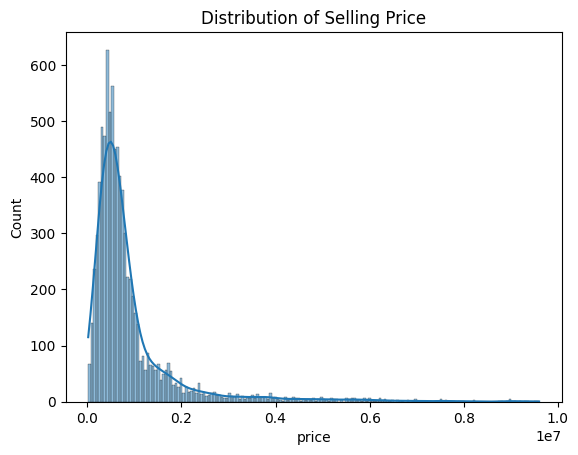

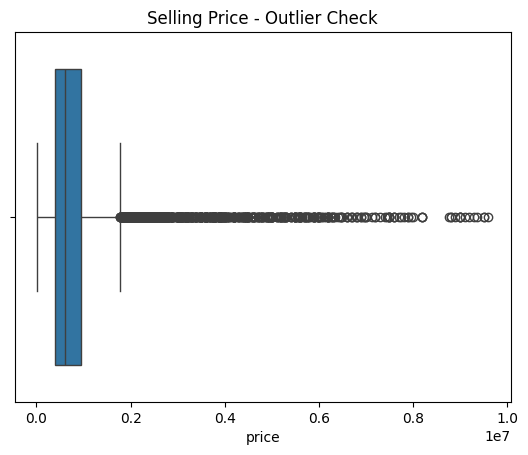

In [18]:
# numerical Features 
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Selling Price
sns.histplot(df_all_cities['price'], kde=True)
plt.title('Distribution of Selling Price')
plt.show()

# Boxplot for selling price
sns.boxplot(x=df_all_cities['price'])
plt.title('Selling Price - Outlier Check')
plt.show()


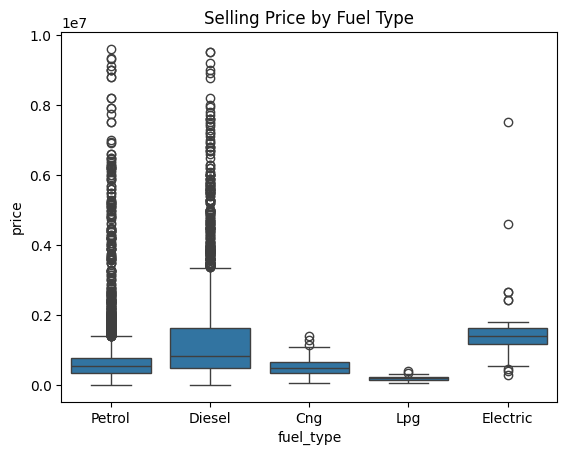

In [19]:
# bivarient Analysis
# selling price vs fuel type 

sns.boxplot(data=df_all_cities, x='fuel_type', y='price')
plt.title('Selling Price by Fuel Type')
plt.show()


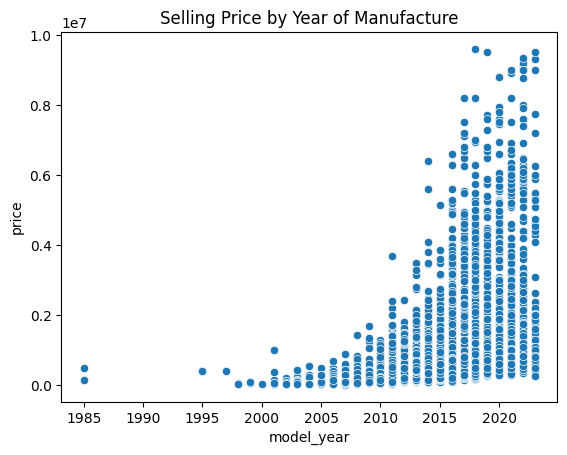

In [20]:
# selling price vs year 


sns.scatterplot(data=df_all_cities, x='model_year', y='price')
plt.title('Selling Price by Year of Manufacture')
plt.show()


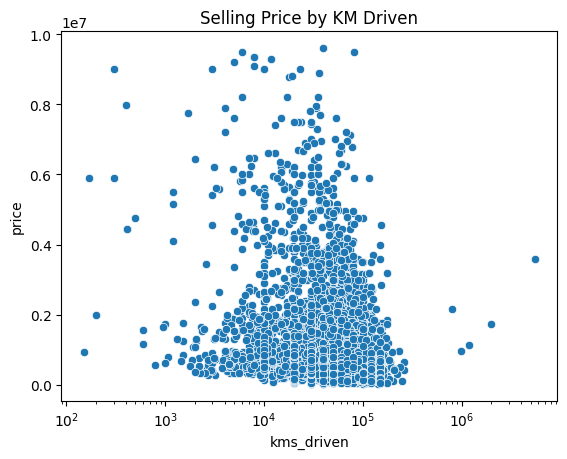

In [21]:
# selling Price vs KM Driven 

sns.scatterplot(data=df_all_cities, x='kms_driven', y='price')
plt.title('Selling Price by KM Driven')
plt.xscale('log')  # if skewed
plt.show()


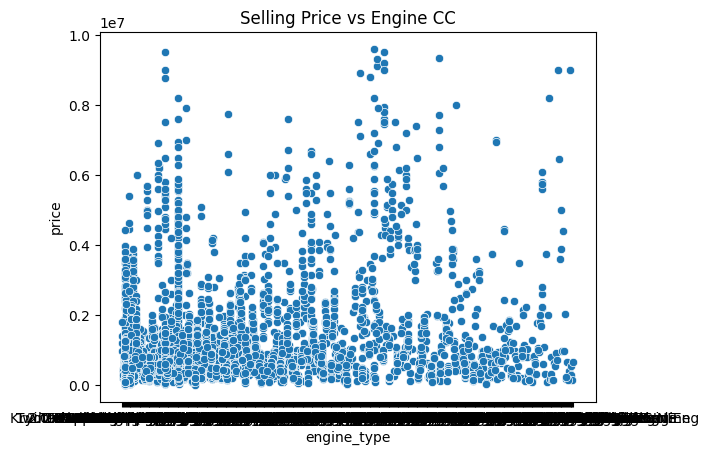

In [22]:
# selling price vs Engine Size
#  
sns.scatterplot(data=df_all_cities, x='engine_type', y='price')
plt.title('Selling Price vs Engine CC')
plt.show()


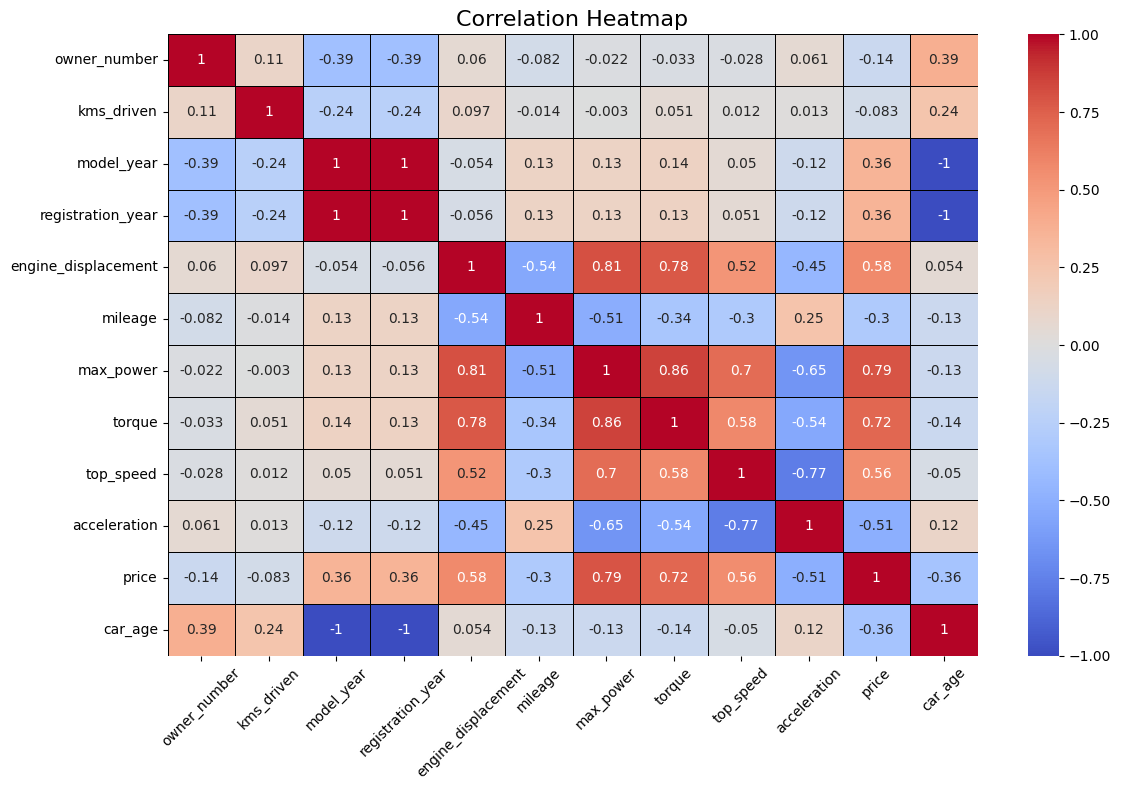

In [23]:
# Correlation Heatmap

plt.figure(figsize=(12, 8))  # Width=12, Height=8 — adjust as needed
sns.heatmap(df_all_cities.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
df_all_cities.describe()

,owner_number,kms_driven,model_year,registration_year,engine_displacement,mileage,max_power,torque,top_speed,acceleration,price,car_age
count,8349.000000,8.349000e+03,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8.349000e+03,8349.000000
mean,1.361001,5.906246e+04,2016.493233,2016.558630,1420.464607,19.269709,104.597157,176.862167,172.974728,12.885699,9.164603e+05,8.506767
std,0.642298,7.412212e+04,3.919605,3.927264,469.697957,3.949639,44.290103,107.562169,20.229060,2.554398,1.062142e+06,3.919605
min,0.000000,0.000000e+00,1985.000000,1985.000000,0.000000,7.500000,25.400000,4.800000,80.000000,4.400000,2.016100e+04,2.000000
25%,1.000000,3.000000e+04,2014.000000,2014.000000,1197.000000,17.010000,78.900000,110.000000,165.000000,12.600000,3.990000e+05,6.000000
50%,1.000000,5.387300e+04,2017.000000,2017.000000,1248.000000,19.030000,88.700000,140.000000,170.000000,12.900000,6.000000e+05,8.000000
75%,2.000000,8.000000e+04,2019.000000,2019.000000,1498.000000,21.400000,118.360000,215.000000,172.000000,13.300000,9.500000e+05,11.000000
max,5.000000,5.500000e+06,2023.000000,2023.000000,5000.000000,140.000000,453.260000,800.000000,285.000000,44.040000,9.600000e+06,40.000000


In [25]:
 #  separating based on dtype
cat_cols = df_all_cities.select_dtypes(include='object').columns.tolist()
num_cols = df_all_cities.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:\n", cat_cols)
print("\nNumerical Columns:\n", num_cols)


Categorical Columns:
 ['brand', 'model', 'variant', 'fuel_type', 'body_type', 'transmission', 'owner_type', 'color', 'engine_type', 'gear_box', 'drive_type', 'steering_type', 'City']

Numerical Columns:
 ['owner_number', 'kms_driven', 'model_year', 'registration_year', 'engine_displacement', 'mileage', 'max_power', 'torque', 'top_speed', 'acceleration', 'price', 'car_age']


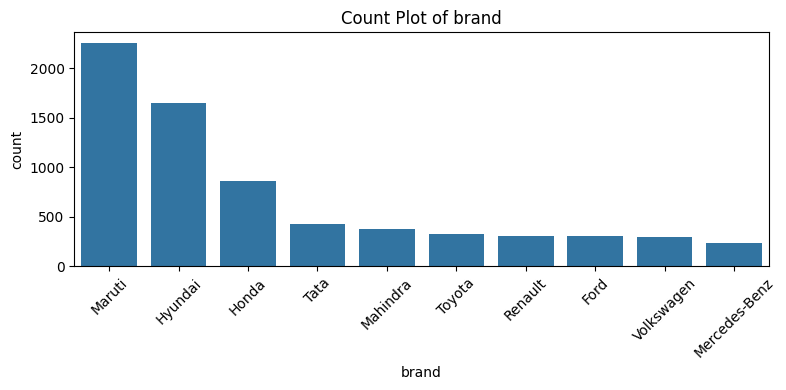

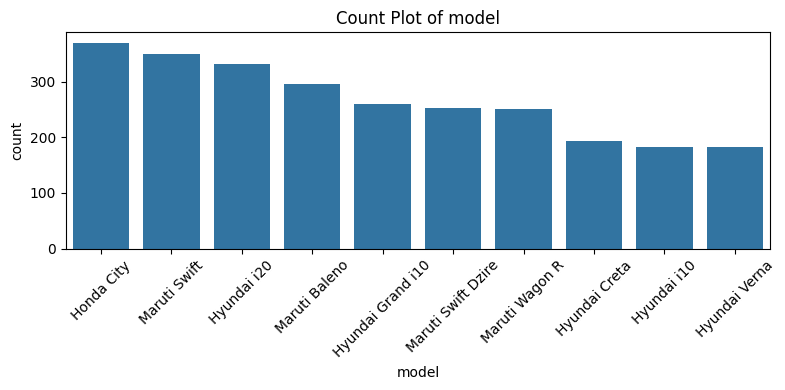

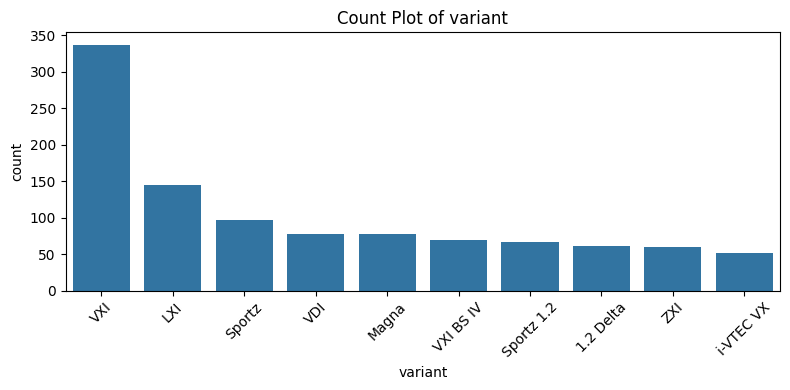

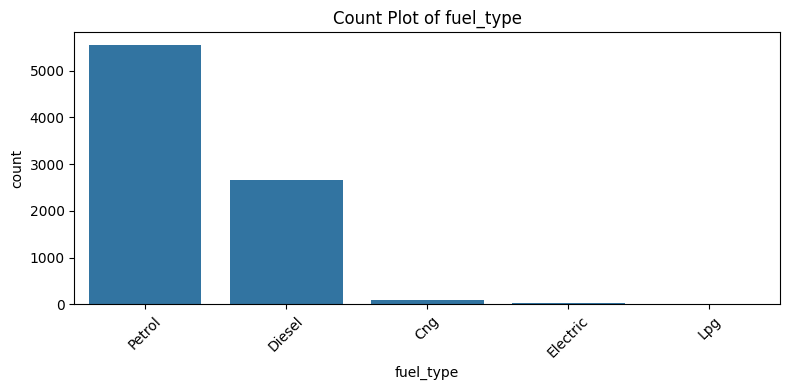

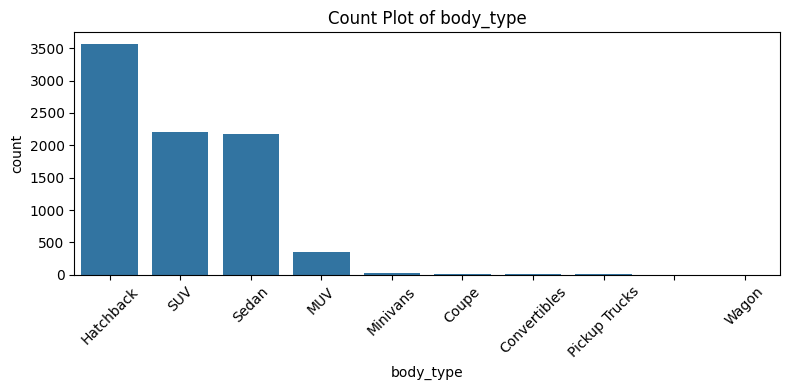

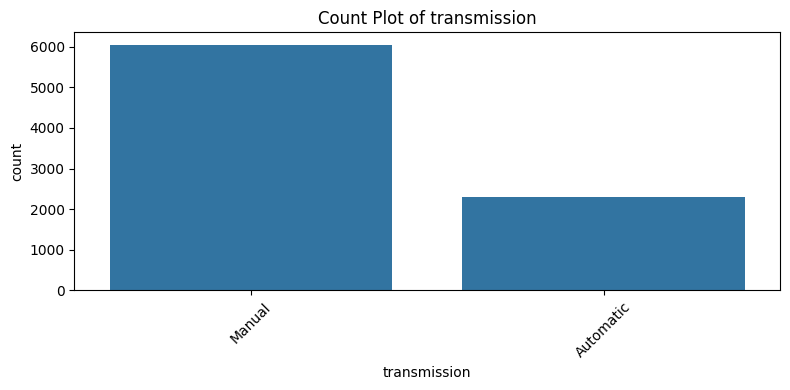

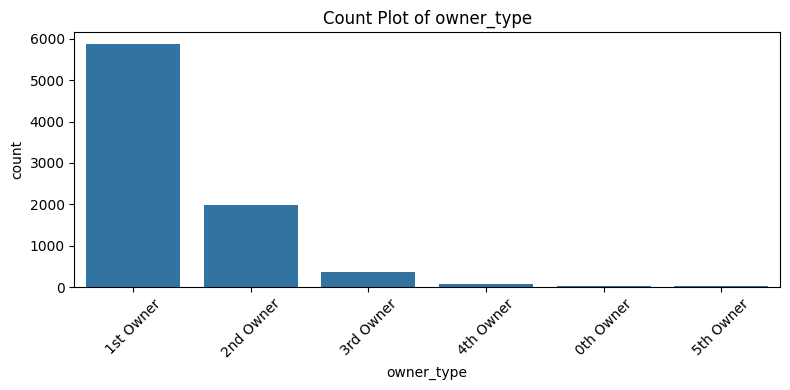

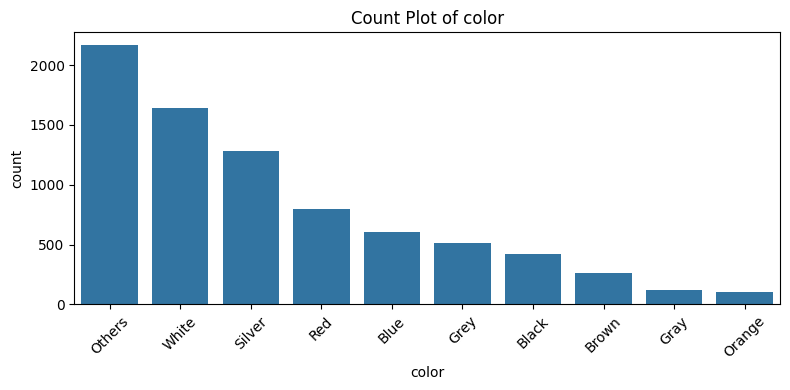

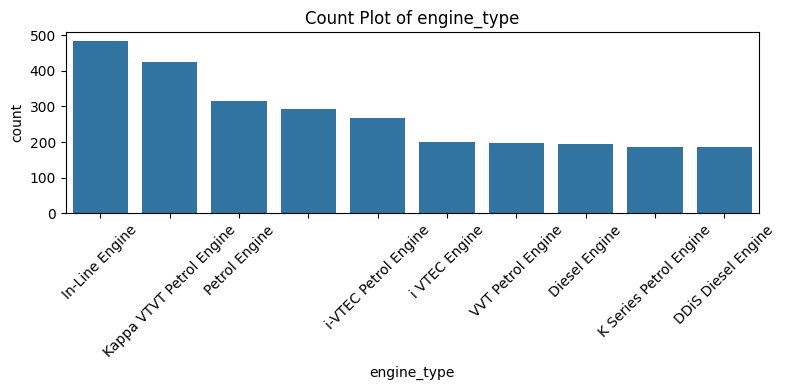

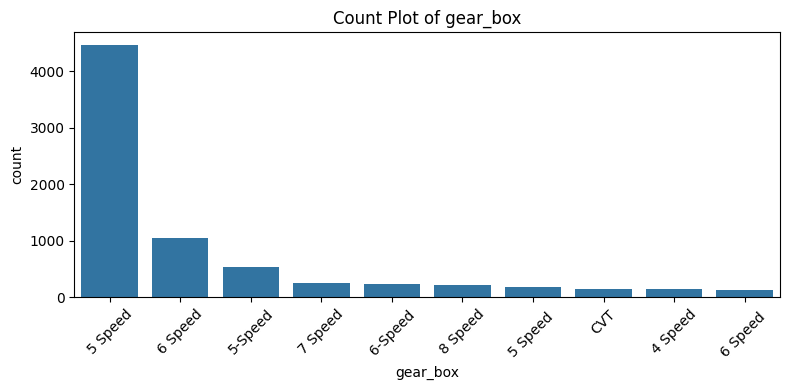

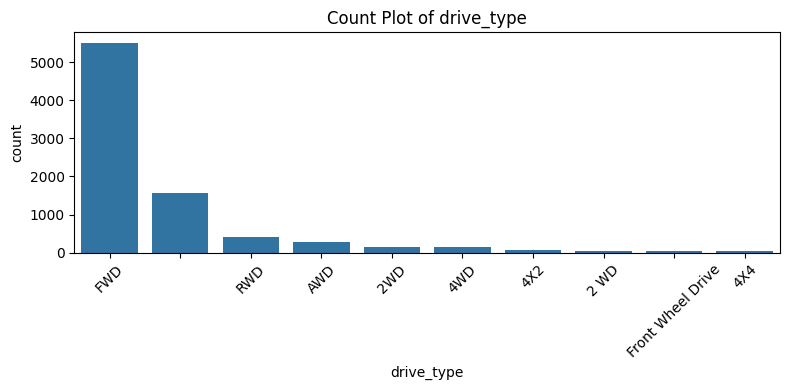

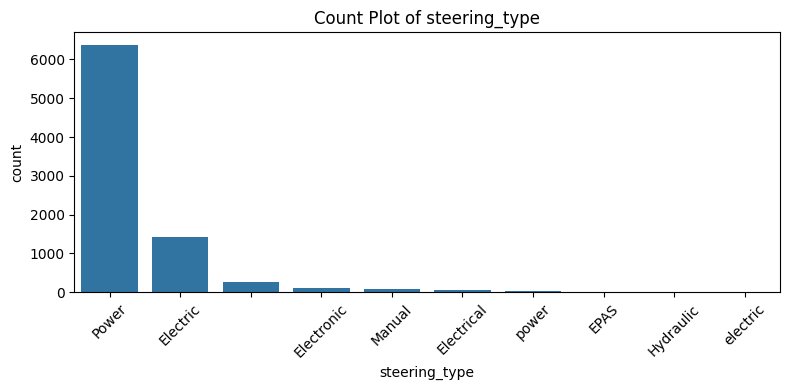

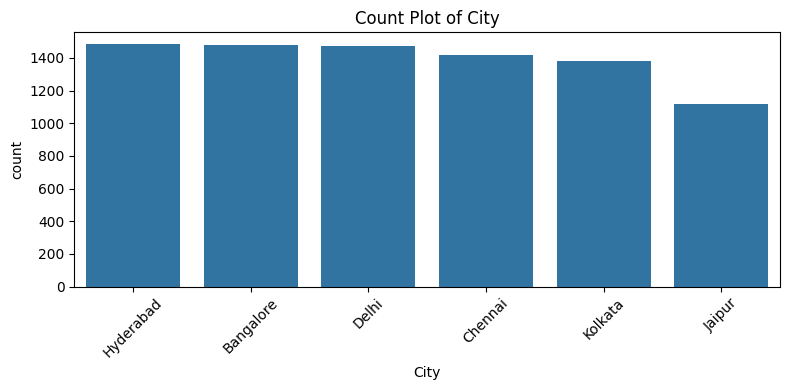

In [26]:
# for catogarical columns 

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_all_cities, x=col, order=df_all_cities[col].value_counts().head(10).index)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


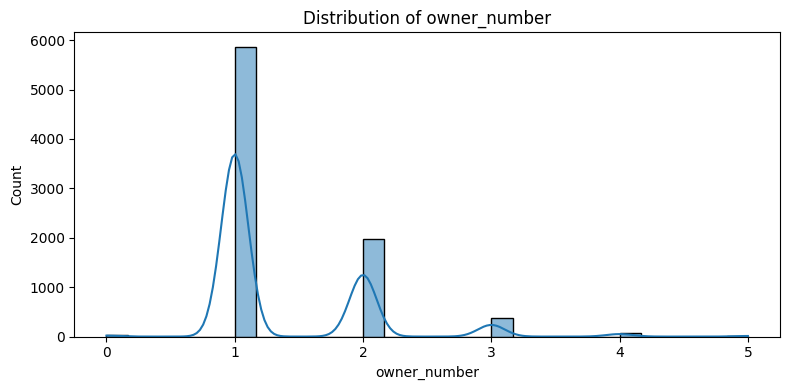

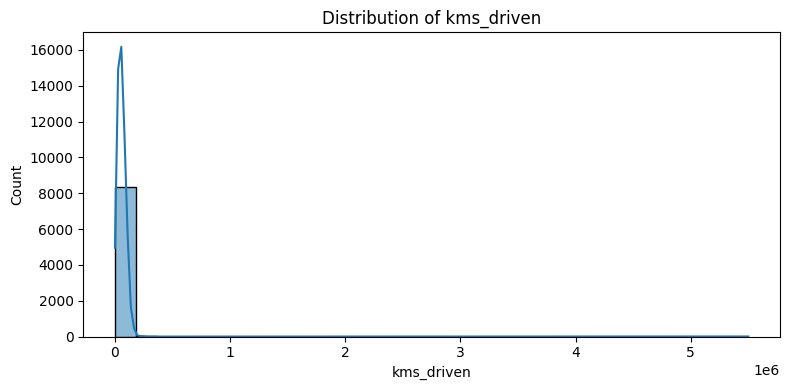

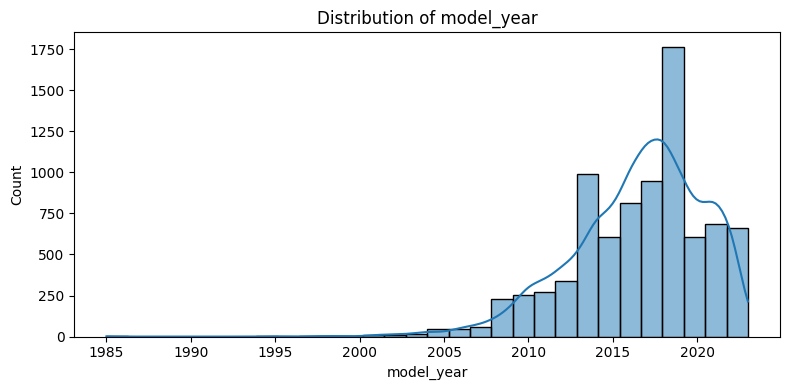

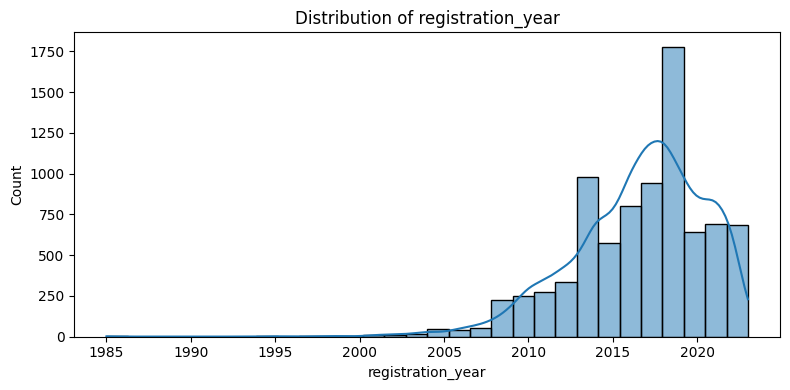

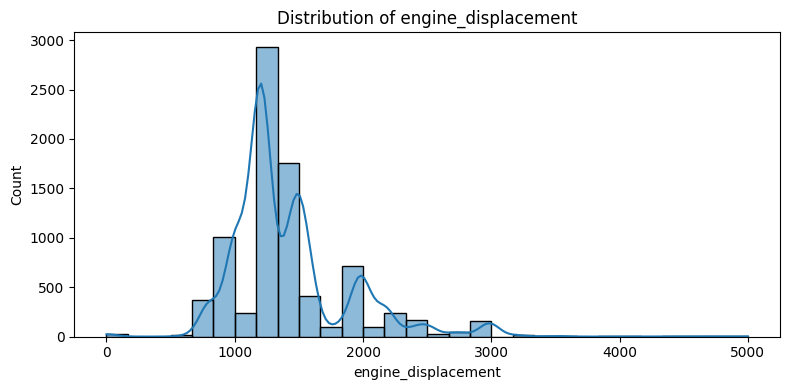

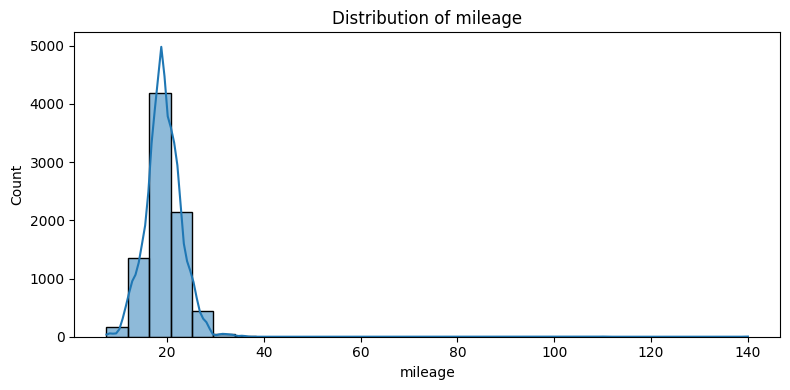

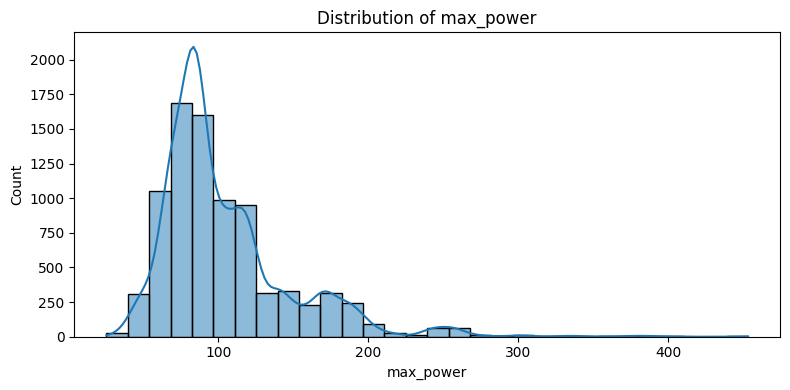

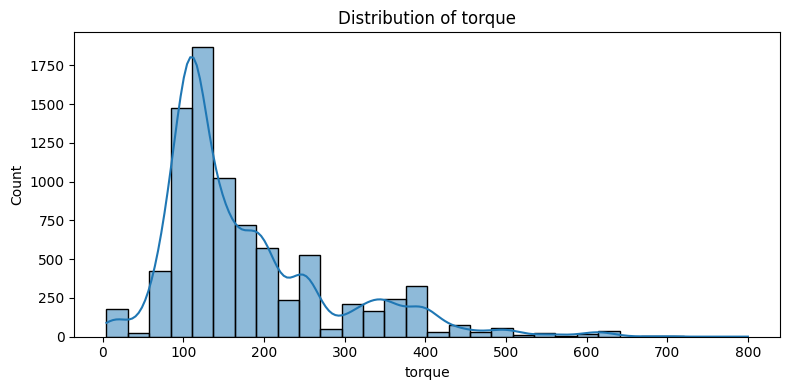

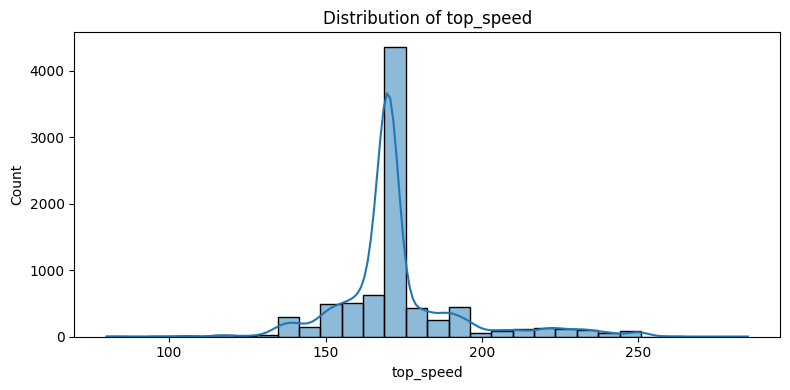

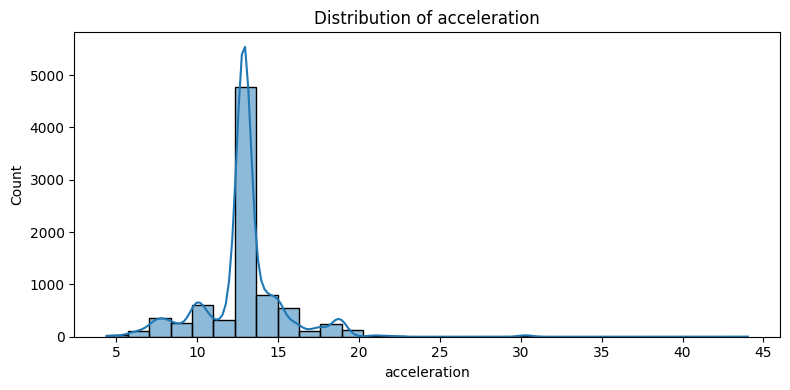

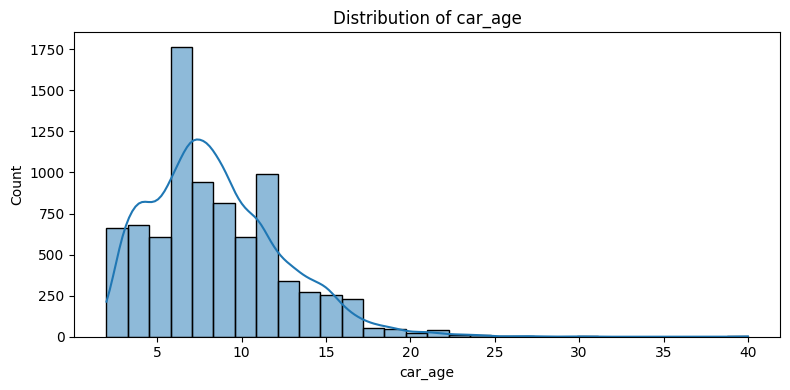

In [27]:
# Histograms
for col in num_cols:
    if col != 'price':  # price will be treated as target
        plt.figure(figsize=(8, 4))
        sns.histplot(df_all_cities[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()



In [28]:
df_all_cities.dtypes

brand                   object
model                   object
variant                 object
fuel_type               object
body_type               object
transmission            object
owner_type              object
owner_number             int64
kms_driven               int64
model_year               int64
registration_year        int64
engine_displacement    float64
mileage                float64
max_power              float64
torque                 float64
color                   object
engine_type             object
gear_box                object
drive_type              object
steering_type           object
top_speed              float64
acceleration           float64
price                  float64
City                    object
car_age                  int64
dtype: object

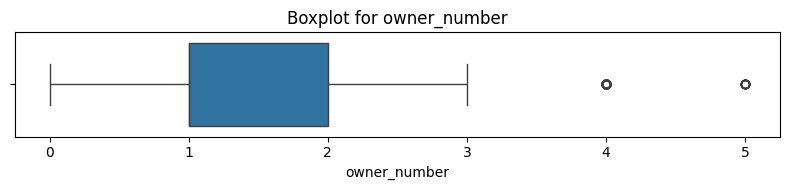

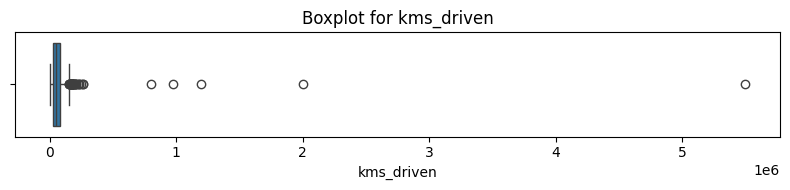

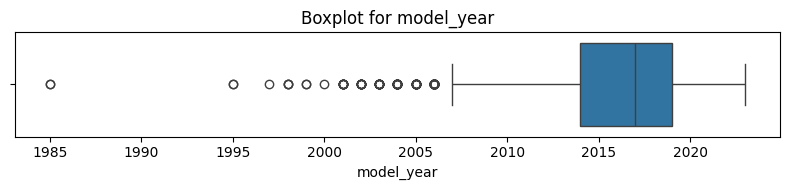

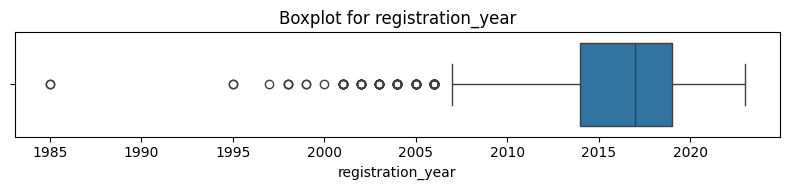

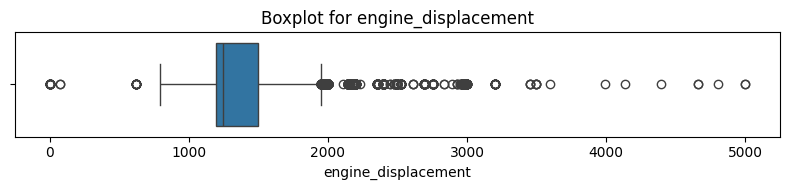

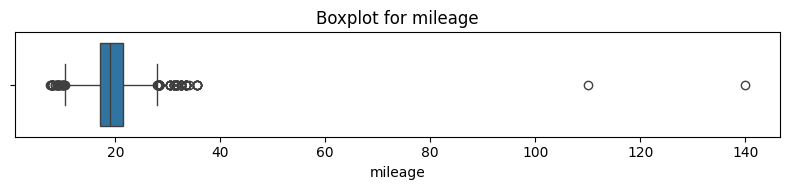

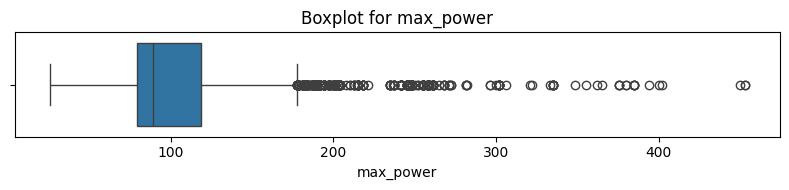

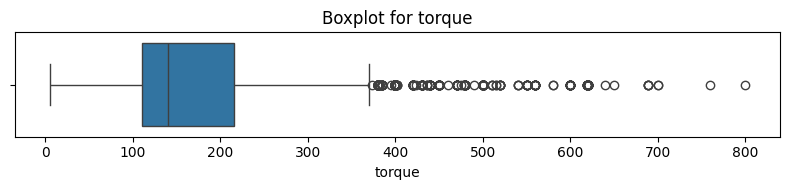

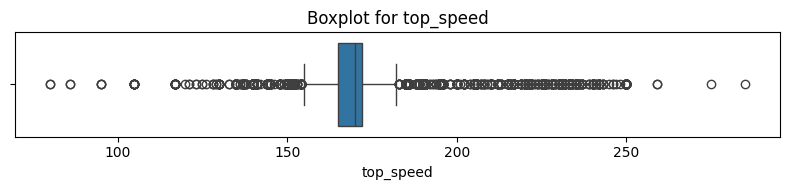

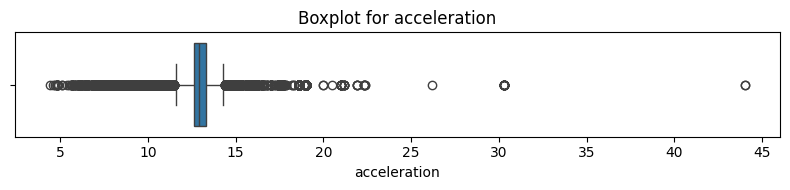

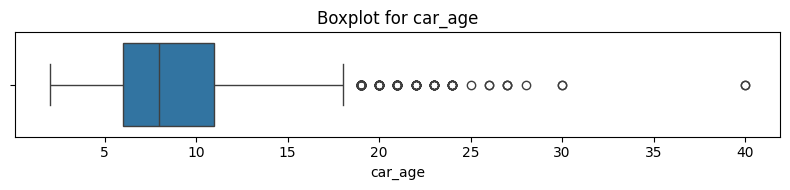

In [29]:


# Boxplots to detect outliers

for col in df_all_cities.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'price':  # price might be your target
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df_all_cities[col])
        plt.title(f'Boxplot for {col}')
        plt.tight_layout()
        plt.show()


In [30]:
# IQR method
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    return outliers

# Detect outliers in all numerical columns except 'price'
outlier_summary = {}
for col in df_all_cities.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'price':
        outliers = detect_outliers_iqr(df_all_cities, col)
        outlier_summary[col] = len(outliers)

# Show columns with outlier counts

pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count']).sort_values(by='Outlier Count', ascending=False)


,Outlier Count
acceleration,2781
top_speed,2311
engine_displacement,1509
torque,622
max_power,598
mileage,148
model_year,132
car_age,132
registration_year,130
owner_number,99


In [31]:
# Define outlier columns
outlier_columns = [
    'acceleration',
    'top_speed',
    'engine_displacement',
    'torque',
    'max_power',
    'mileage',
    'model_year',
    'car_age',
    'registration_year',
    'owner_number',
    'kms_driven'
]

# Define the function
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# Apply it
df_no_outliers = remove_outliers_iqr(df_all_cities, outlier_columns)

# Check result
print("Original Shape:", df_all_cities.shape)
print("After Removing Outliers:", df_no_outliers.shape)


Original Shape: (8349, 25)
After Removing Outliers: (2357, 25)


In [32]:
# Select only the most outlier-prone columns
high_outlier_cols = ['acceleration', 'top_speed', 'engine_displacement']

df_less_aggressive = remove_outliers_iqr(df_all_cities, high_outlier_cols)
print("Less Aggressive Shape:", df_less_aggressive.shape)


Less Aggressive Shape: (3302, 25)


In [33]:
def cap_outliers_iqr(df, columns):
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = df_capped[col].clip(lower, upper)
    return df_capped

df_capped = cap_outliers_iqr(df_all_cities, outlier_columns)
print("Capped Shape:", df_capped.shape)


Capped Shape: (8349, 25)


In [34]:
# cheing the data type  befor ml 
df_capped.dtypes


brand                   object
model                   object
variant                 object
fuel_type               object
body_type               object
transmission            object
owner_type              object
owner_number           float64
kms_driven               int64
model_year             float64
registration_year      float64
engine_displacement    float64
mileage                float64
max_power              float64
torque                 float64
color                   object
engine_type             object
gear_box                object
drive_type              object
steering_type           object
top_speed              float64
acceleration           float64
price                  float64
City                    object
car_age                float64
dtype: object

In [35]:
# Convert to integer where appropriate
df_capped['model_year'] = df_capped['model_year'].astype(int)
df_capped['registration_year'] = df_capped['registration_year'].astype(int)
df_capped['owner_number'] = df_capped['owner_number'].astype(int)
df_capped['car_age'] = df_capped['car_age'].astype(int)


In [36]:
# separate features 
num_cols = df_capped.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical Columns:", num_cols)


Numerical Columns: ['kms_driven', 'engine_displacement', 'mileage', 'max_power', 'torque', 'top_speed', 'acceleration', 'price']


In [37]:
cat_cols = df_capped.select_dtypes(include='object').columns.tolist()
print("Categorical Columns:", cat_cols)


Categorical Columns: ['brand', 'model', 'variant', 'fuel_type', 'body_type', 'transmission', 'owner_type', 'color', 'engine_type', 'gear_box', 'drive_type', 'steering_type', 'City']


In [38]:
df_capped.dtypes

brand                   object
model                   object
variant                 object
fuel_type               object
body_type               object
transmission            object
owner_type              object
owner_number             int32
kms_driven               int64
model_year               int32
registration_year        int32
engine_displacement    float64
mileage                float64
max_power              float64
torque                 float64
color                   object
engine_type             object
gear_box                object
drive_type              object
steering_type           object
top_speed              float64
acceleration           float64
price                  float64
City                    object
car_age                  int32
dtype: object

In [40]:
# Save the final cleaned structured DataFrame
df_capped.to_csv("cleaned_car_data.csv", index=False)


In [41]:
# encoding categorical features 
df_encoded = pd.get_dummies(df_capped, columns=cat_cols, drop_first=True)


In [42]:
print(df_encoded.shape)
print(df_encoded.head())


(8349, 3313)
   owner_number  kms_driven  model_year  registration_year  \
0             3       70000        2014               2014   
1             1       23981        2017               2017   
2             1        7100        2021               2021   
3             2       71574        2011               2012   
4             2       50000        2014               2014   

   engine_displacement  mileage  max_power  torque  top_speed  acceleration  \
0               1949.5    19.16     158.20   213.0      170.0         12.90   
1                799.0    22.70      53.64    72.0      170.0         12.90   
2                999.0    19.03      71.01    96.0      170.0         12.90   
3               1197.0    17.00      80.00    11.4      170.0         12.96   
4               1949.5    15.73     174.33   372.5      182.5         11.55   

   ...  steering_type_Hydraulic  steering_type_Manual  steering_type_Power  \
0  ...                    False                 False        

In [43]:
# dimentionality check  to many  dummies 

df_capped['model'].nunique()
df_capped['variant'].nunique()
df_capped['color'].nunique()



154

In [44]:
print(df_encoded.shape)   # should show (8349, 154)


(8349, 3313)


In [45]:


def reduce_cardinality(df, column, top_n=30):
    """Replace rare categories in a column with 'Other'."""
    top_categories = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
    return df

# Create a working copy
df_reduced = df_capped.copy()

# Reduce high-cardinality columns
df_reduced = reduce_cardinality(df_reduced, 'model', top_n=30)
df_reduced = reduce_cardinality(df_reduced, 'variant', top_n=30)
df_reduced = reduce_cardinality(df_reduced, 'color', top_n=15)  # or exclude if not useful

# Drop original dataframe if needed
# df_reduced.drop(['color'], axis=1, inplace=True)  # Optional

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_reduced, drop_first=True)

# Final shape
print("Final Encoded Shape:", df_encoded.shape)
df_encoded.head()


Final Encoded Shape: (8349, 785)


,owner_number,kms_driven,model_year,registration_year,engine_displacement,mileage,max_power,torque,top_speed,acceleration,...,steering_type_Hydraulic,steering_type_Manual,steering_type_Power,steering_type_electric,steering_type_power,City_Chennai,City_Delhi,City_Hyderabad,City_Jaipur,City_Kolkata
0,3,70000,2014,2014,1949.5,19.16,158.20,213.0,170.0,12.90,...,False,False,True,False,False,False,False,False,False,True
1,1,23981,2017,2017,799.0,22.70,53.64,72.0,170.0,12.90,...,False,False,True,False,False,False,False,False,False,True
2,1,7100,2021,2021,999.0,19.03,71.01,96.0,170.0,12.90,...,False,False,False,False,False,False,False,False,False,True
3,2,71574,2011,2012,1197.0,17.00,80.00,11.4,170.0,12.96,...,False,False,True,False,False,False,False,False,False,True
4,2,50000,2014,2014,1949.5,15.73,174.33,372.5,182.5,11.55,...,False,False,True,False,False,False,False,False,False,True


In [ ]:
!pipinstall xgboost


  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 163.8 kB/s eta 0:15:16
   ---------------------------------------- 0.0/150.0 MB 163.8 kB/s eta 0:15:16
   ---------------------------------------- 0.0/150.0 MB 164.3 kB/s eta 0:15:13
   ---------------------------------------- 0.1/150.0 MB 269.5 kB/s eta 0:09:17
   ---------------------------------------- 0.1/150.0 MB 379.3 kB/s eta 0:06:36
   ---------------------------------------- 0.2/150.0 MB 656.0 kB/s eta 0:03:49
   ---------------------------------------- 0.4/150.0 MB 983.6 kB/s eta 0:02:33
   ---------------------------------------- 0.6/150.0 MB 1.3 MB/s eta 0:01:52
   -----

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 b4c89b71d134da9fa6318e3c9f5459317d1013b4d57059d10ed2840750e2f7e1
             Got        24366f4691e7bb9b2b9a96ece47c2ec118c7ad79450c8b20df3f213fcab3d45c


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



   ---- ---------------------------------- 18.4/150.0 MB 650.1 kB/s eta 0:03:23
   ---- ---------------------------------- 18.5/150.0 MB 648.2 kB/s eta 0:03:23
   ---- ---------------------------------- 18.5/150.0 MB 648.2 kB/s eta 0:03:23
   ---- ---------------------------------- 18.5/150.0 MB 645.0 kB/s eta 0:03:24
   ---- ---------------------------------- 18.5/150.0 MB 644.4 kB/s eta 0:03:25
   ---- ---------------------------------- 18.5/150.0 MB 641.8 kB/s eta 0:03:25
   ---- ---------------------------------- 18.5/150.0 MB 640.0 kB/s eta 0:03:26
   ---- ---------------------------------- 18.5/150.0 MB 640.0 kB/s eta 0:03:26
   ---- ---------------------------------- 18.5/150.0 MB 637.5 kB/s eta 0:03:27
   ---- ---------------------------------- 18.6/150.0 MB 635.6 kB/s eta 0:03:27
   ---- ---------------------------------- 18.6/150.0 MB 634.4 kB/s eta 0:03:28
   ---- ---------------------------------- 18.6/150.0 MB 632.0 kB/s eta 0:03:28
   ---- -------------------------------

In [50]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

import pickle

# 1. Load your encoded data
df = df_encoded.copy()  # Assuming df_encoded is your final encoded DataFrame

# 2. Define features and target
X = df.drop("price", axis=1)
y = df["price"]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42)
}

# 5. Model Training and Evaluation

results = []

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_score = np.mean(cross_val_score(pipe, X, y, cv=5, scoring='r2'))

    results.append({
        "Model": name,
        "R2 Score": r2,
        "MAE": mae,
        "RMSE": rmse,
        "CV R2": cv_score
    })

    print(f"\n{name} Performance:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Cross-Val R2: {cv_score:.4f}")

# 6. Create Results DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print("\nModel Comparison:")
print(results_df)

# 7. Export the Best Model and Feature Columns
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Create and fit the final pipeline
final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', best_model)
])
final_pipe.fit(X, y)

# Save the pipeline model
with open(f'{best_model_name}_best_car_price_model.pkl', 'wb') as f:
    pickle.dump(final_pipe, f)

# Save the feature columns
with open('model_features_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print(f"\n Best model pipeline saved as '{best_model_name}_best_car_price_model.pkl'")
print(" Feature columns saved as 'model_features_columns.pkl'")



LinearRegression Performance:
R2 Score: 0.8901
MAE: 167205.33
RMSE: 331377.20
Cross-Val R2: 0.8319

Ridge Performance:
R2 Score: 0.8906
MAE: 166745.55
RMSE: 330668.80
Cross-Val R2: 0.8321


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e+14, tolerance: 7.748e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.623e+14, tolerance: 7.298e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p


Lasso Performance:
R2 Score: 0.8899
MAE: 167311.04
RMSE: 331691.26
Cross-Val R2: 0.8277

RandomForest Performance:
R2 Score: 0.9370
MAE: 111030.21
RMSE: 250938.06
Cross-Val R2: 0.8993

GradientBoosting Performance:
R2 Score: 0.9091
MAE: 161700.61
RMSE: 301405.76
Cross-Val R2: 0.8873

XGBoost Performance:
R2 Score: 0.9498
MAE: 100334.37
RMSE: 223951.95
Cross-Val R2: 0.9145

Model Comparison:
              Model  R2 Score            MAE           RMSE     CV R2
5           XGBoost  0.949807  100334.367120  223951.949654  0.914491
3      RandomForest  0.936982  111030.212024  250938.056218  0.899295
4  GradientBoosting  0.909085  161700.611938  301405.760057  0.887329
1             Ridge  0.890574  166745.546873  330668.795158  0.832122
0  LinearRegression  0.890105  167205.330313  331377.199335  0.831888
2             Lasso  0.889897  167311.036289  331691.256906  0.827736

 Best model pipeline saved as 'XGBoost_best_car_price_model.pkl'
 Feature columns saved as 'model_features_columns